In [ ]:
%matplotlib inline


# Synthetic disturbance data
This example illustrates the simulation of a near real time monitoring scenario on synthetic data.
The EWMA approach instantiated from ``nrt.monitor.ewma import EWMA`` is used for monitoring and detection
of the artificially generated breakpoints and the experiment is concluded by a simple accuracy assessment.


# Synthetic data generation

The data module of the nrt package contains functionalities to create synthetic
data with controlled parameters such as position of structural change, phenological
amplitude, noise level, etc
One such example can be visualized using the ``make_ts`` function, which
creates a single time-series.



In [1]:
import numpy as np


def make_ts(dates, break_idx=-1, intercept=0.7, amplitude=0.15, magnitude=0.25,
            recovery_time=1095, sigma_noise=0.02, n_outlier=3,
            outlier_value=-0.1, n_nan=3):
    """Simulate a harmonic time-series with optional breakpoint, noise and outliers

    The time-series is generated by adding;
    - an intercept/trend component which varies depending on the phase of the time-series
    (stable, recovery)
    - An annual seasonal component
    - Random noise drawn from a normal distribution (white noise)
    Optional outliers are then added to randomly chosen observation as well as ``np.Nan`` values.
    Note that the seasonal cycles simulation approach used here is rather simplistic,
    using a sinusoidal model and therefore assuming symetrical and regular behaviour
    around the peak of the simulated variable. Actual vegetation signal is often more
    asymetrical and irregular.

    Args:
        dates (array-like): List or array of dates (numpy.datetime64)
        break_idx (int): Breakpoint index in the date array provided. Defaults to
            ``-1``, corresponding to a stable time-series
        intercept (float): Intercept of the time-series
        amplitude (float): Amplitude of the harmonic model (note that at every point
            of the time-series, the actual model amplitude is multiplied by the intercept
        magnitude (float): Break magnitude (always a drop in y value)
        recovery_time (int): Time (in days) to recover the initial intersect value
            following a break
        sigma_noise (float): Sigma value of the normal distribution (mean = 0) from which
            noise values are drawn
        n_outlier (int): Number of outliers randomly assigned to observations of the
            time-series
        outlier_value (float): Value to assign to outliers
        n_nan (int): Number of ``np.nan`` (no data) assigned to observations of the
            time-series

    Example:
        >>> from nrt import data
        >>> import numpy as np
        >>> import matplotlib.pyplot as plt

        >>> dates = np.arange('2018-01-01', '2022-06-15', dtype='datetime64[W]')
        >>> ts = data.make_ts(dates=dates, break_idx=30)

        >>> plt.plot(dates, ts)
        >>> plt.show()

    Returns:
        np.ndarray: Array of simulated values of same size as ``dates``
    """
    dates = dates.astype('datetime64[D]')
    timestamps = dates.astype(int)
    ydays = (dates - dates.astype('datetime64[Y]')).astype(int) + 1
    y = np.empty_like(dates, dtype=np.float64)
    # Intercept array
    y[:] = intercept
    # Build trend segment if break
    if break_idx != -1:
        # Segment bounds
        segment_start_y = intercept - magnitude
        segment_start_timestamp = timestamps[break_idx]
        segment_end_timestamp = segment_start_timestamp + recovery_time
        segment_end_idx = np.abs(segment_end_timestamp - timestamps).argmin()
        # Compute y values
        recovery_rate = magnitude / recovery_time
        days_since_break = timestamps - segment_start_timestamp
        trend_segment = (recovery_rate * days_since_break + segment_start_y)[break_idx + 1:segment_end_idx + 1]
        # include into y
        y[break_idx + 1:segment_end_idx + 1] = trend_segment
    # Seasonality
    amplitude_values = amplitude * y
    season = amplitude * np.sin(2 * np.pi * timestamps / 365.25 - 2)
    # noise and outliers
    noise = np.random.normal(0, sigma_noise, dates.size)
    # Combine the 3 (trend, season, noise) components
    ts = y + season + noise
    # Add optional outliers and Nans
    outliers_idx = np.random.choice(np.arange(0, dates.size), size=n_outlier, replace=False)
    nan_idx = np.random.choice(np.arange(0, dates.size), size=n_nan)
    ts[outliers_idx] = outlier_value
    ts[nan_idx] = np.nan
    return ts

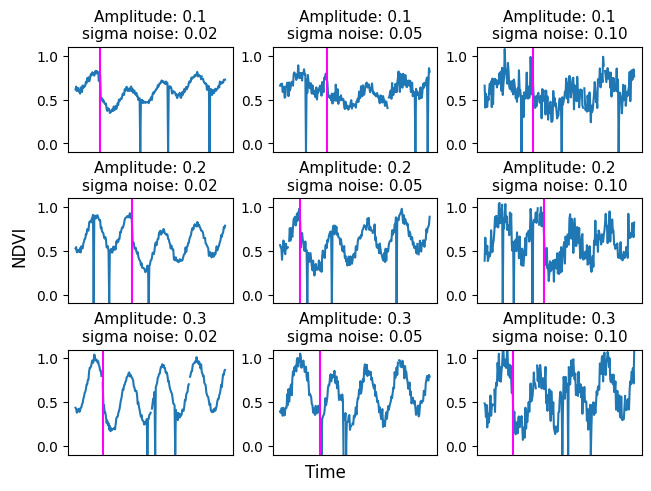

In [3]:
import random

import numpy as np
from nrt import data
# from nrt.data import make_ts
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

dates = np.arange('2018-01-01', '2022-06-15', dtype='datetime64[W]')
fig, axes = plt.subplots(3,3, constrained_layout=True)
for row, amplitude in zip(axes, [0.1, 0.2, 0.3]):
    for ax, noise in zip(row, [0.02, 0.05, 0.1]):
        break_idx = random.randint(30,100)
        ts = make_ts(dates=dates,
                          break_idx=break_idx,
                          sigma_noise=noise,
                          amplitude=amplitude)
        ax.plot(dates, ts)
        ax.axvline(x=dates[break_idx], color='magenta')
        ax.set_ylim(-0.1,1.1)
        ax.set_title('Amplitude: %.1f\nsigma noise: %.2f' % (amplitude, noise),
                     fontsize=11)
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%Y"))
        ax.tick_params( axis='x', which='both', bottom=False, top=False,
                       labelbottom=False)
fig.supxlabel('Time')
fig.supylabel('NDVI')
plt.show()

The spatial counterpart of ``make_ts`` is ``make_cube`` and its main argument
is an ``xarray.Dataset`` of simulation parameters that can be generated
with the ``make_cube_parameters`` function.
The data cube generated is a standard univariate ``xarray.DataArray`` with
``x``, ``y`` and ``time`` dimensions. Each pixel in the spatial dimensions contains
a time-series of simulated values with varying levels of noise, seasonality, outliers
and in some cases a structural break point



In [8]:
import xarray as xr


def make_cube_parameters(shape=(100,100),
                         break_idx_interval=(0,100),
                         intercept_interval=(0.6, 0.8),
                         amplitude_interval=(0.12, 0.2),
                         magnitude_interval=(0.2, 0.3),
                         recovery_time_interval=(800,1400),
                         sigma_noise_interval=(0.02, 0.04),
                         n_outliers_interval=(0,5),
                         n_nan_interval=(0,5),
                         unstable_proportion=0.5):
    """Create ``xarray.Dataset`` of paramters for generation of synthetic data cube

    Prepares the main input required by the the ``make_cube`` function. This
    intermediary step eases the creation of multiple synthetic DataArrays sharing
    similar characteristics (e.g. to simulate multispectral data)

    Args:
        shape (tuple): A size two integer tuple giving the x,y size of the Dataset to be
            generated
        break_idx_interval (tuple): A tuple of two integers indicating the interval
            from which the breakpoint position in the time-series is drawn. Generate
            array of random values passed to the ``break_idx` argument of ``make_ts``.
            Similarly to python ranges, upper bound value is excluded from the resulting
            array. To produce a zero filled array ``(0,1)`` can therefore be used
            TODO: add a default to allow breakpoint at any location (conflict with Nan that indicate no break)
        intercept_interval (tuple): A tuple of two floats providing the interval
            from which intercept is drawn. Generate array of random values passed
            to the ``intercept`` argument of ``make_ts``
        amplitude_interval (tuple): A tuple of two floats indicating the interval
            from which the seasonal amplitude parameter is drawn. Generate array
            of random values passed to the ``amplitude`` argument of ``make_ts``
        magnitude_interval (tuple): A tuple of two floats indicating the interval
            from which the breakpoint magnitude parameter is drawn. Generate array
            of random values passed to the ``magnitude`` argument of ``make_ts``
        recovery_time_interval (tuple): A tuple of two integers indicating the interval
            from which the recovery time parameter (in days) is drawn. Generate array
            of random values passed to the ``recovery_time` argument of ``make_ts``
        sigma_noise_interval (tuple): A tuple of two floats indicating the interval
            from which the white noise level is drawn. Generate array of random
            values passed to the ``sigma_noise` argument of ``make_ts``
        n_outliers_interval (tuple): A tuple of two integers indicating the interval
            from which the number of outliers is drawn. Generate array
            of random values passed to the ``n_outliers` argument of ``make_ts``
        n_nan_interval (tuple): A tuple of two integers indicating the interval
            from which the number of no-data observations is drawn. Generate array
            of random values passed to the ``n_nan` argument of ``make_ts``
        unstable_proportion (float): Proportion of time-series containing a breakpoint.
            The other time-series are stable.

    Returns:
        xarray.Dataset: Dataset with arrays of parameters required for the generation
            of synthetic time-series using the spatialized version of ``make_ts``
            (see ``make_cube``)

    Examples:
        >>> import time
        >>> import numpy as np
        >>> import xarray as xr
        >>> from nrt import data
        >>> import matplotlib.pyplot as plt
        >>> params_nir = data.make_cube_parameters(shape=(20,20),
        ...                                        n_outliers_interval=(0,1),
        ...                                        n_nan_interval=(0,1),
        ...                                        break_idx_interval=(50,100))
        >>> params_red = params_nir.copy(deep=True)
        >>> # create parameters for red, green, blue cubes by slightly adjusting intercept,
        >>> # magnitude and amplitude parameters
        >>> params_red['intercept'].data = np.random.uniform(0.09, 0.12, size=(20,20))
        >>> params_red['magnitude'].data = np.random.uniform(-0.1, -0.03, size=(20,20))
        >>> params_red['amplitude'].data = np.random.uniform(0.03, 0.07, size=(20,20))
        >>> params_green = params_nir.copy(deep=True)
        >>> params_green['intercept'].data = np.random.uniform(0.12, 0.20, size=(20,20))
        >>> params_green['magnitude'].data = np.random.uniform(0.05, 0.1, size=(20,20))
        >>> params_green['amplitude'].data = np.random.uniform(0.05, 0.08, size=(20,20))
        >>> params_blue = params_nir.copy(deep=True)
        >>> params_blue['intercept'].data = np.random.uniform(0.08, 0.13, size=(20,20))
        >>> params_blue['magnitude'].data = np.random.uniform(-0.01, 0.01, size=(20,20))
        >>> params_blue['amplitude'].data = np.random.uniform(0.02, 0.04, size=(20,20))
        >>> dates = np.arange('2018-01-01', '2022-06-15', dtype='datetime64[W]')
        >>> # Create cubes (DataArrays) and merge them into a sligle Dataset
        >>> nir = data.make_cube(dates, name='nir', params_ds=params_nir)
        >>> red = data.make_cube(dates, name='red', params_ds=params_red)
        >>> green = data.make_cube(dates, name='green', params_ds=params_green)
        >>> blue = data.make_cube(dates, name='blue', params_ds=params_blue)
        >>> cube = xr.merge([blue, green, red, nir]).to_array()
        >>> # PLot one ts
        >>> cube.isel(x=5, y=5).plot(row='variable')
        >>> plt.show()
    """
    intercept = np.random.uniform(*intercept_interval, size=shape)
    amplitude = np.random.uniform(*amplitude_interval, size=shape)
    magnitude = np.random.uniform(*magnitude_interval, size=shape)
    recovery_time = np.random.randint(*recovery_time_interval, size=shape)
    sigma_noise = np.random.uniform(*sigma_noise_interval, size=shape)
    n_outlier = np.random.randint(*n_outliers_interval, size=shape)
    n_nan = np.random.randint(*n_nan_interval, size=shape)
    break_idx = np.random.randint(*break_idx_interval, size=shape)
    # Make a proportion of these cells stable
    size = np.multiply(*shape)
    stable_size = size - round(unstable_proportion * size)
    break_idx.ravel()[np.random.choice(size, stable_size, replace=False)] = -1
    # Build Dataset of parameters
    params = xr.Dataset(data_vars={'intercept': (['y', 'x'], intercept),
                                   'amplitude': (['y', 'x'], amplitude),
                                   'magnitude': (['y', 'x'], magnitude),
                                   'recovery_time': (['y', 'x'], recovery_time),
                                   'sigma_noise': (['y', 'x'], sigma_noise),
                                   'n_outlier': (['y', 'x'], n_outlier),
                                   'n_nan': (['y', 'x'], n_nan),
                                   'break_idx': (['y', 'x'], break_idx)},
                        coords={'y': np.arange(shape[0]),
                                'x': np.arange(shape[1])})
    return params

def make_cube(dates, params_ds, outlier_value=0.1, name='ndvi'):
    """Generate a cube of synthetic time-series

    See ``make_ts`` for more details on how every single time-series is generated

    Args:
        dates (array-like): List or array of dates (numpy.datetime64)
        params_ds (xarray.Dataset): Dataset containing arrays of time-series generation
            parameters. See ``make_cube_parameters`` for a helper to generate such Dataset.
            Spatial dimensions of the params_ds Dataset are used for the generated cube
        outlier_value (float): Value to assign to outliers
        name (str): Name of the generated variable in the DataArray

    Return:
        xarray.DataArray: Cube of synthetic time-series generated using the paramters
            provided via ``param_ds`` Dataset.

    Example:
        >>> import time
        >>> import numpy as np
        >>> from nrt import data
        >>> import matplotlib.pyplot as plt
        >>> dates = np.arange('2018-01-01', '2022-06-15', dtype='datetime64[W]')
        >>> params_ds = data.make_cube_parameters(shape=(100,100),
        ...                                  n_outliers_interval=(0,5),
        ...                                  n_nan_interval=(0,7),
        ...                                  break_idx_interval=(100,dates.size - 20))
        >>> cube = data.make_cube(dates=dates, params_ds=params_ds)
        >>> # PLot one ts
        >>> cube.isel(x=5, y=5).plot()
        >>> plt.show()
    """
    nrows, ncols = params_ds.intercept.data.shape
    # Vectorize function
    make_ts_v = np.vectorize(make_ts, signature='(n),(),(),(),(),(),(),(),(),()->(n)')
    # Create output array
    out = make_ts_v(dates=dates,
                    break_idx=params_ds.break_idx.data,
                    intercept=params_ds.intercept.data,
                    amplitude=params_ds.amplitude.data,
                    magnitude=params_ds.magnitude.data,
                    recovery_time=params_ds.recovery_time.data,
                    sigma_noise=params_ds.sigma_noise.data,
                    n_outlier=params_ds.n_outlier.data,
                    outlier_value=outlier_value,
                    n_nan=params_ds.n_nan.data)
    # Build xarray dataset
    xr_cube = xr.DataArray(data=np.moveaxis(out, -1, 0),
                           coords={'time': dates,
                                   'y': np.arange(nrows),
                                   'x': np.arange(ncols)},
                          name=name)
    return xr_cube

In [9]:
params_ds = make_cube_parameters(shape=(50,50),
                                      n_outliers_interval=(0,5),
                                      n_nan_interval=(0,7),
                                      break_idx_interval=(105,dates.size - 20))
# Convert break_idx to dates
print('Early breakpoint: %s' % dates[105])
print('Late breakpoint: %s' % dates[dates.size - 20])
cube = make_cube(dates=dates, params_ds=params_ds)

Early breakpoint: 2020-01-02
Late breakpoint: 2022-01-20


/var/folders/57/xjqy04fx2lzb16rmc3h3l1cc0000gn/T/ipykernel_6134/1734377735.py:165: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xr_cube = xr.DataArray(data=np.moveaxis(out, -1, 0),


In the ndvi datacube created, 50 percents of the pixels contain a break point
occuring between 2020-01-02 and 2022-01-20. The ``break_idx`` variable of
the ``params_ds`` ``Dataset`` informs on the presence or absence of a break point,
and its position.



# Simulation of an NRT monitoring scenario
For the simulating a near real time monitoring scenario, we consider all the pixels
of the datacube (no mask) and define the 2018-01-01 to 2019-12-31 period as the
stable history period and all subsequent dates as monitoring. We know from the
time-series simulation parameters that the stable history period is indeed free of breakpoints.
In a real life near real time monitoring use case, fitting and monitoring are
occuring separately; we therefore need to split the datacube created in two.

After that instantiation of the ``EWMA`` class and stable history takes place.
The harmonic fit parameters for each pixel is stored in the instance
of the ``EWMA`` class
Note that in a real life scenario, several days may pass between fitting and the
next observation, or between consecutive observations. The fit parameters or
ongoing monitoring variables are then usually stored to disk in a NetCDF file.
See the ``to_netcdf()`` method for more details. 
During monitoring each new observation needs to be passed to the monitor method 
as a numpy array. Since we currently have these observations in an xarray DataArray
structure, we need to unpack each temporal slice as an (array, date) tuple



In [12]:
import datetime

from nrt.monitor.ewma import EWMA

cube_history = cube.sel(time=slice('2018-01-01','2019-12-31'))
cube_monitor = cube.sel(time=slice('2020-01-01', '2022-12-31'))

# Monitoring class instantiation and fitting
monitor = EWMA(trend=False, harmonic_order=1, lambda_=0.3, sensitivity=4,
               threshold_outlier=10)
monitor.fit(dataarray=cube_history)

# Monitor every date of the ``cube_monitor`` DataArray
for array, date in zip(cube_monitor.values,
                       cube_monitor.time.values.astype('M8[s]').astype(datetime.datetime)):
    monitor.monitor(array=array, date=date)

In [15]:
monitor._report(layers=['detection_date'], dtype=np.uint16)

array([[[19005, 18354, 18277, ...,     0,     0, 18277],
        [18284, 18844, 18858, ...,     0, 18907,     0],
        [    0,     0, 18767, ...,     0,     0, 18774],
        ...,
        [    0, 18886, 18690, ..., 18984, 19033, 18361],
        [18942, 18473, 18606, ..., 18634,     0, 18823],
        [    0,     0, 18592, ...,     0, 18865,     0]]], dtype=uint16)

# Monitoring performances evaluation
Assessing the performance of a time-series monitoring algorithm can be a complex
task that depends on the specific use case and what the user wants to emphasize.
A user valuing rapid detection will chose an assessment approach that puts extra
weight on the temporal aspect or penalize late detections, while if timeliness
is not a requirement, accuracy assessment will resemble standard spatial validation.
In the present example we work with a temporal threshold for which 6 months is the
default value. This approach to accuracy assessment implies that any breakpoint
occuring outside of the 6 months periods after the simulated breakpoint (considered ground thruth)
is considered comission error. Absence of detection during that same period would then be
an omission, detections during the period are true positives, and absence of detection
on stable time-series are true negatives.
Note that alternative accuracy assessment approaches exist; see for instance [1]_ who
chose to use ``PixelYears`` as their sampling units, or [2]_ who introduced the
concept of a time weighted F1 score, hence considerating simultaneously detection
speed and spatial accuracy in a single index.



In [18]:
def accuracy(nrtInstance, params_ds, dates, delta=180):
    """Compute accuracy metrics (precision, recall) of a nrt simulation on synthetic data

    Args:
        nrtInstance: Instance of a nrt monitoring class used for monitoring
        params_ds: Time-series generation paramaters
        dates: Array of numpy.datetime64 dates used for synthetic time-series generation
        delta (int): Time delta in day after a reference break for a detected break
            to be considered True Positive.
    """
    detection_date = nrtInstance._report(layers=['detection_date'], dtype=np.uint16)
    dates_true = np.where(params_ds.break_idx != -1,
                          dates[params_ds.break_idx.values],
                          np.datetime64('NaT'))
    dates_true_bound = dates_true + np.timedelta64(delta)
    dates_pred = np.datetime64('1970-01-01') + np.timedelta64(1) * detection_date
    dates_pred[dates_pred == np.datetime64('1970-01-01')] = np.datetime64('NaT')
    # Computes arrays of TP, FP, FN (they should be mutually exclusive)
    TP = np.where(np.logical_and(dates_pred >= dates_true, dates_pred <= dates_true_bound),
                  1, 0)
    FP = np.where(np.logical_and(TP == 0, ~np.isnat(dates_pred)), 1, 0)
    FN = np.where(np.logical_and(np.isnat(dates_pred), ~np.isnat(dates_true)), 1, 0)
    precision = TP.sum() / (TP.sum() + FP.sum())
    recall = TP.sum() / (TP.sum() + FN.sum())
    return precision, recall

print(accuracy(monitor, params_ds, dates))

(0.8842592592592593, 0.9695431472081218)


# White noise sensitivity analysis
To go one step further we can assess and visualize how these accuracy measures
vary with the amount of noise present in the synthetic data.
For that we define a new function encompassing all the steps of data generation,
instantiation, fitting and monitoring

The increase in recall at low noise levels is probably due to the extreme outliers
filtering feature of the EWMA monitoring process, OUtliers that exceed ``threshold_outlier``
times the standard deviation of the fit residuals are considered extreme
outliers (often clouds or artifacts) in real images, and do not contribute to the monitoring
process. With such low noise levels, that threshold is easily reached and breaks missed.



In [19]:
def make_cube_parameters(shape=(100,100),
                         break_idx_interval=(0,100),
                         intercept_interval=(0.6, 0.8),
                         amplitude_interval=(0.12, 0.2),
                         magnitude_interval=(0.2, 0.3),
                         recovery_time_interval=(800,1400),
                         sigma_noise_interval=(0.02, 0.04),
                         n_outliers_interval=(0,5),
                         n_nan_interval=(0,5),
                         unstable_proportion=0.5):
    """Create ``xarray.Dataset`` of paramters for generation of synthetic data cube

    Prepares the main input required by the the ``make_cube`` function. This
    intermediary step eases the creation of multiple synthetic DataArrays sharing
    similar characteristics (e.g. to simulate multispectral data)

    Args:
        shape (tuple): A size two integer tuple giving the x,y size of the Dataset to be
            generated
        break_idx_interval (tuple): A tuple of two integers indicating the interval
            from which the breakpoint position in the time-series is drawn. Generate
            array of random values passed to the ``break_idx` argument of ``make_ts``.
            Similarly to python ranges, upper bound value is excluded from the resulting
            array. To produce a zero filled array ``(0,1)`` can therefore be used
            TODO: add a default to allow breakpoint at any location (conflict with Nan that indicate no break)
        intercept_interval (tuple): A tuple of two floats providing the interval
            from which intercept is drawn. Generate array of random values passed
            to the ``intercept`` argument of ``make_ts``
        amplitude_interval (tuple): A tuple of two floats indicating the interval
            from which the seasonal amplitude parameter is drawn. Generate array
            of random values passed to the ``amplitude`` argument of ``make_ts``
        magnitude_interval (tuple): A tuple of two floats indicating the interval
            from which the breakpoint magnitude parameter is drawn. Generate array
            of random values passed to the ``magnitude`` argument of ``make_ts``
        recovery_time_interval (tuple): A tuple of two integers indicating the interval
            from which the recovery time parameter (in days) is drawn. Generate array
            of random values passed to the ``recovery_time` argument of ``make_ts``
        sigma_noise_interval (tuple): A tuple of two floats indicating the interval
            from which the white noise level is drawn. Generate array of random
            values passed to the ``sigma_noise` argument of ``make_ts``
        n_outliers_interval (tuple): A tuple of two integers indicating the interval
            from which the number of outliers is drawn. Generate array
            of random values passed to the ``n_outliers` argument of ``make_ts``
        n_nan_interval (tuple): A tuple of two integers indicating the interval
            from which the number of no-data observations is drawn. Generate array
            of random values passed to the ``n_nan` argument of ``make_ts``
        unstable_proportion (float): Proportion of time-series containing a breakpoint.
            The other time-series are stable.

    Returns:
        xarray.Dataset: Dataset with arrays of parameters required for the generation
            of synthetic time-series using the spatialized version of ``make_ts``
            (see ``make_cube``)

    Examples:
        >>> import time
        >>> import numpy as np
        >>> import xarray as xr
        >>> from nrt import data
        >>> import matplotlib.pyplot as plt
        >>> params_nir = data.make_cube_parameters(shape=(20,20),
        ...                                        n_outliers_interval=(0,1),
        ...                                        n_nan_interval=(0,1),
        ...                                        break_idx_interval=(50,100))
        >>> params_red = params_nir.copy(deep=True)
        >>> # create parameters for red, green, blue cubes by slightly adjusting intercept,
        >>> # magnitude and amplitude parameters
        >>> params_red['intercept'].data = np.random.uniform(0.09, 0.12, size=(20,20))
        >>> params_red['magnitude'].data = np.random.uniform(-0.1, -0.03, size=(20,20))
        >>> params_red['amplitude'].data = np.random.uniform(0.03, 0.07, size=(20,20))
        >>> params_green = params_nir.copy(deep=True)
        >>> params_green['intercept'].data = np.random.uniform(0.12, 0.20, size=(20,20))
        >>> params_green['magnitude'].data = np.random.uniform(0.05, 0.1, size=(20,20))
        >>> params_green['amplitude'].data = np.random.uniform(0.05, 0.08, size=(20,20))
        >>> params_blue = params_nir.copy(deep=True)
        >>> params_blue['intercept'].data = np.random.uniform(0.08, 0.13, size=(20,20))
        >>> params_blue['magnitude'].data = np.random.uniform(-0.01, 0.01, size=(20,20))
        >>> params_blue['amplitude'].data = np.random.uniform(0.02, 0.04, size=(20,20))
        >>> dates = np.arange('2018-01-01', '2022-06-15', dtype='datetime64[W]')
        >>> # Create cubes (DataArrays) and merge them into a sligle Dataset
        >>> nir = data.make_cube(dates, name='nir', params_ds=params_nir)
        >>> red = data.make_cube(dates, name='red', params_ds=params_red)
        >>> green = data.make_cube(dates, name='green', params_ds=params_green)
        >>> blue = data.make_cube(dates, name='blue', params_ds=params_blue)
        >>> cube = xr.merge([blue, green, red, nir]).to_array()
        >>> # PLot one ts
        >>> cube.isel(x=5, y=5).plot(row='variable')
        >>> plt.show()
    """
    intercept = np.random.uniform(*intercept_interval, size=shape)
    amplitude = np.random.uniform(*amplitude_interval, size=shape)
    magnitude = np.random.uniform(*magnitude_interval, size=shape)
    recovery_time = np.random.randint(*recovery_time_interval, size=shape)
    sigma_noise = np.random.uniform(*sigma_noise_interval, size=shape)
    n_outlier = np.random.randint(*n_outliers_interval, size=shape)
    n_nan = np.random.randint(*n_nan_interval, size=shape)
    break_idx = np.random.randint(*break_idx_interval, size=shape)
    # Make a proportion of these cells stable
    size = np.multiply(*shape)
    stable_size = size - round(unstable_proportion * size)
    break_idx.ravel()[np.random.choice(size, stable_size, replace=False)] = -1
    # Build Dataset of parameters
    params = xr.Dataset(data_vars={'intercept': (['y', 'x'], intercept),
                                   'amplitude': (['y', 'x'], amplitude),
                                   'magnitude': (['y', 'x'], magnitude),
                                   'recovery_time': (['y', 'x'], recovery_time),
                                   'sigma_noise': (['y', 'x'], sigma_noise),
                                   'n_outlier': (['y', 'x'], n_outlier),
                                   'n_nan': (['y', 'x'], n_nan),
                                   'break_idx': (['y', 'x'], break_idx)},
                        coords={'y': np.arange(shape[0]),
                                'x': np.arange(shape[1])})
    return params

/var/folders/57/xjqy04fx2lzb16rmc3h3l1cc0000gn/T/ipykernel_6134/1734377735.py:165: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xr_cube = xr.DataArray(data=np.moveaxis(out, -1, 0),
/var/folders/57/xjqy04fx2lzb16rmc3h3l1cc0000gn/T/ipykernel_6134/1734377735.py:165: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 val

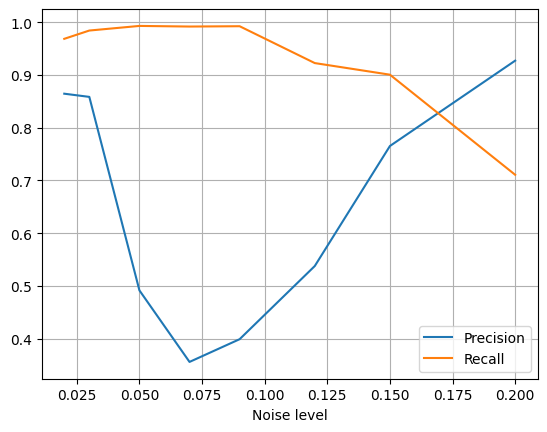

In [20]:
def make_cube_fit_and_monitor(dates, noise_level):
    params_ds = make_cube_parameters(shape=(20,20),
                                          n_outliers_interval=(4,5),
                                          n_nan_interval=(3,4),
                                          sigma_noise_interval=(noise_level, noise_level),
                                          break_idx_interval=(105,dates.size - 20))
    cube = make_cube(dates=dates, params_ds=params_ds)
    cube_history = cube.sel(time=slice('2018-01-01','2019-12-31'))
    cube_monitor = cube.sel(time=slice('2020-01-01', '2022-12-31'))
    # Monitoring class instantiation and fitting
    monitor = EWMA(trend=False, harmonic_order=1, lambda_=0.3, sensitivity=4,
                   threshold_outlier=10)
    monitor.fit(dataarray=cube_history)
    # Monitor every date of the ``cube_monitor`` DataArray
    for array, date in zip(cube_monitor.values,
                           cube_monitor.time.values.astype('M8[s]').astype(datetime.datetime)):
        monitor.monitor(array=array, date=date)
    return params_ds, monitor

noises = [0.02, 0.03, 0.05, 0.07, 0.09, 0.12, 0.15, 0.2]
prs = []
for noise in noises:
    params_ds, monitor = make_cube_fit_and_monitor(dates, noise)
    prs.append(accuracy(monitor, params_ds, dates))

precisions, recalls = zip(*prs)
plt.plot(noises, precisions, label='Precision')
plt.plot(noises, recalls, label='Recall')
plt.xlabel('Noise level')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## References

.. [1] Bullock, E.L., Woodcock, C.E. and Holden, C.E., 2020. Improved
       change monitoring using an ensemble of time series algorithms.
       Remote Sensing of Environment, 238, p.111165.

.. [2] Viehweger, J., 2021. Comparative Assessment of Near Real-Time Forest
       Disturbance Detection Algorithms. Master thesis, Philipps Universitat
       Marburg

